Notebook for segmenting person from background.

- To set custom background, add desired background image into folder '/background'
- Image size is set at 1024px in length.

# Set up environment
Set Runtime type to GPU

In [1]:
### SET UP

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!pip install -q torch torchvision
#!pip install supervision==0.12.0

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-q2vk9_ou
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-q2vk9_ou
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=14a0cd22ac0d161b12abb41ee00515528d45644cd759d54c05294555564367f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6qqlat7/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
work_dir = os.getcwd()
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {work_dir}/GroundingDINO
!git checkout -q
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 443 (delta 156), reused 138 (delta 129), pack-reused 233
Receiving objects: 100% (443/443), 12.86 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (228/228), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00


In [3]:
import os
%cd /content
work_dir = os.getcwd()
%cd {work_dir}
!mkdir -p {work_dir}/weights
%cd {work_dir}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content
/content/weights


# Assign config paths

In [4]:
%cd /content
import os
work_dir = os.getcwd()

/content


In [5]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [6]:
%cd {work_dir}/GroundingDINO
MODEL_TYPE = "vit_h"
CONFIG_PATH = '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(work_dir, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

from groundingdino.util.inference import load_model, load_image, predict, annotate
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO
/content/weights/groundingdino_swint_ogc.pth ; exist: True


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
%cd {work_dir}/GroundingDINO

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

/content/GroundingDINO


## Assign image file path

In [206]:
import cv2
import supervision as sv
import numpy as np

IMAGE_PATH = '/content/images/pexels-photo-762020.webp' #'/content/images/pexels-photo-2182970.webp'#'/content/headshot-male-winter-portrait-4079ce836b716d5ad050972ee894cbad.jpg'
max_length = 600#1024
white_background='No'

BACKGROUND_IMAGE_PATH = '/content/images/office_pexels-photo-380769.webp'

ORI_IMAGE_PATH = IMAGE_PATH
image_file_name = IMAGE_PATH.split('/images/')[-1].split('.')[0]


try:
  print(BACKGROUND_IMAGE_PATH)
  print('Have background')
  have_background='Yes'
except NameError:
  print('No background')
  have_background='No'

from PIL import Image

def resize_image(image_path, max_length):
    # Open the image file
    image = Image.open(image_path)

    # Get the dimensions of the image
    width, height = image.size
    # Calculate the aspect ratio
    aspect_ratio = width / height
    # Determine which side to resize
    if width > height:
        new_width = max_length
        new_height = int(max_length / aspect_ratio)
    else:
        new_height = max_length
        new_width = int(max_length * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    return resized_image

/content/images/office_pexels-photo-380769.webp
Have background


In [188]:
if have_background == 'No':
  print('No background ----------------')
  img = cv2.imread(IMAGE_PATH)
  img_height, img_width = img.shape[:2]
  if img_height > max_length:
    resize ='Yes'
  else:
    resize = 'No'
    IMAGE_PATH = ORI_IMAGE_PATH
  if resize=='Yes':
    IMAGE_PATH = os.path.join(work_dir,image_file_name + "_" + "resized.png")
    resized_image = resize_image(IMAGE_PATH, max_length)
    resized_image.save(IMAGE_PATH)

In [207]:
from skimage.transform import resize
if have_background=='Yes':
  img = cv2.imread(IMAGE_PATH)
  background_img = cv2.imread(BACKGROUND_IMAGE_PATH)
  print(background_img.shape)
  bg_height, bg_width = background_img.shape[:2]
  img_height, img_width = img.shape[:2]
  if img_height/bg_height < 0.6:
    IMAGE_PATH = os.path.join(work_dir,image_file_name + "_" + "resized.png")
    scale2Background='Yes'
    print(f'ratio: {round(img_height/bg_height,2)}')
    #cv2.imwrite(IMAGE_PATH, img)
    scaling_factor = 0.85/ (img_height/bg_height)#2
    img_resized = resize(img, (int(img.shape[0] * scaling_factor), int(img.shape[1] * scaling_factor)))
    #cv2.imwrite(IMAGE_PATH, img_resized)
    print(img_resized.shape)
    #img_resized = Image.fromarray(img_resized) #  mode='RGB'

    img_resized = Image.fromarray((img_resized * 255).astype(np.uint8))
    #img_resized.save(IMAGE_PATH)
    image_bgr = np.array(img_resized)
  else:
    IMAGE_PATH = ORI_IMAGE_PATH
    print('No need scale')
    image_bgr = cv2.imread(IMAGE_PATH)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_original = image_bgr

(707, 1260, 3)
ratio: 0.57
(600, 901, 3)


In [54]:
%cd {work_dir}/GroundingDINO
from groundingdino.util.inference import Model
CONFIG_PATH = '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
CHECKPOINT_PATH = '/content/weights/groundingdino_swint_ogc.pth'

model = Model(model_config_path=CONFIG_PATH,
                 model_checkpoint_path=CHECKPOINT_PATH)

/content/GroundingDINO
final text_encoder_type: bert-base-uncased


# Object detection

In [208]:
# Detect objects
CLASSES = ['person']
detections = model.predict_with_classes(
    image=image_rgb,
    classes=CLASSES,
    box_threshold=0.35,
    text_threshold=0.25
)

print(detections.xyxy, type(detections.xyxy))
detected_boxes = detections.xyxy
class_id = detections.class_id

[[122.80374   28.348358 772.7423   599.9203  ]] <class 'numpy.ndarray'>


In [209]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import supervision as sv
box_annotator = sv.BoxAnnotator()

mask_annotator =  sv.MaskAnnotator(color=sv.Color.blue())
segmented_mask = []
counter = 0
for dbox in detected_boxes:
    dbox = np.array(dbox)
    print(dbox)

    mask_predictor.set_image(image_rgb)
    masks, scores, logits = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=dbox,
        multimask_output=False
    )

    segmented_mask.append(masks)
    print(len(masks), masks.shape)

    # plot mask on image using supervision
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )

    detections = detections[detections.area == np.max(detections.area)]
    print(CLASSES[class_id[counter]])

    annotated_image = box_annotator.annotate(scene=image_original.copy(), detections=detections, skip_label=False, labels=[CLASSES[class_id[counter]]])
    image_original = annotated_image

    counter+=1

SupervisionWarnings: blue is deprecated: `Color.blue()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.BLUE` instead.


[122.80374   28.348358 772.7423   599.9203  ]
1 (1, 600, 901)
person


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


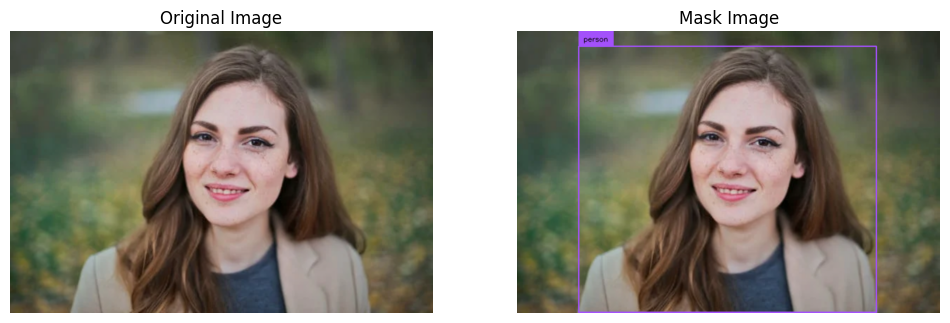

In [210]:
# SHOW BOUNDING BOX AROUND OBJECT ------------------------
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1,2),
    titles=['Original Image', 'Mask Image']

)

In [211]:
print(len(segmented_mask), type(segmented_mask[0]), segmented_mask[0].shape)

for i in range(len(segmented_mask)):

  segmented_mask[i] = segmented_mask[i].transpose(1,2,0)
  segmented_mask[i] = np.array(segmented_mask[i]*255).astype('uint8')
  segmented_mask[i]  = cv2.cvtColor(segmented_mask[i] , cv2.COLOR_GRAY2BGR)


print(segmented_mask[0].shape)

1 <class 'numpy.ndarray'> (1, 600, 901)
(600, 901, 3)


## Show mask

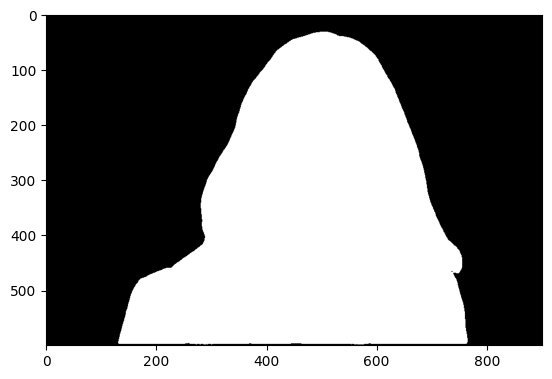

In [212]:
import matplotlib.pyplot as plt

# Show mask
plt.imshow(segmented_mask[0])

Witho white background

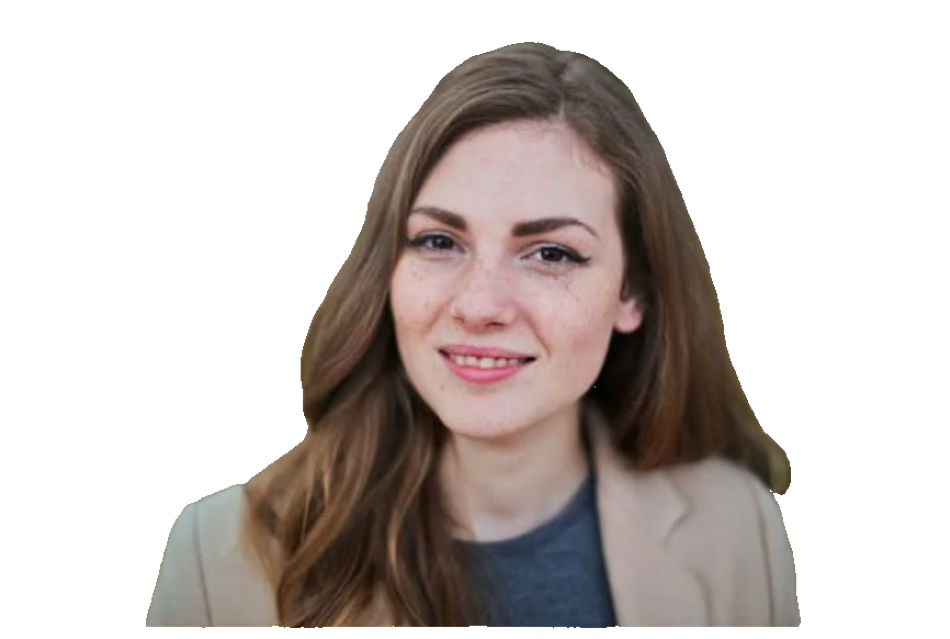

In [195]:
if white_background=='Yes':
  segmented_image = segmented_mask[0]
  segmented_image = cv2.bitwise_and(segmented_image, image_bgr)
  segmented_image[np.where((segmented_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]  # for white background
sv.plot_image(segmented_image)

Without white background

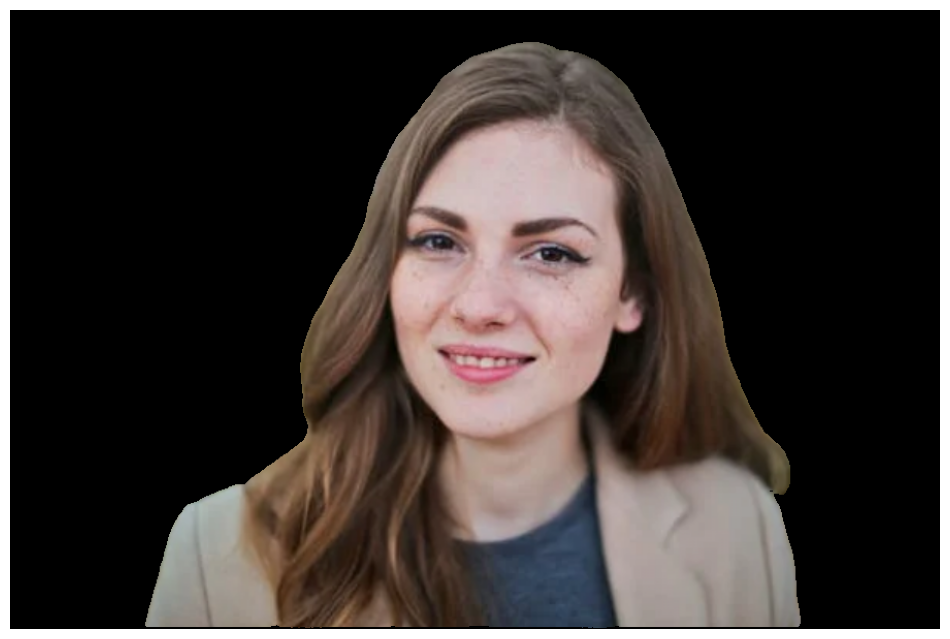

In [213]:
white_background='No'
if white_background=='No':
  segmented_image = segmented_mask[0]
  segmented_image = cv2.bitwise_and(segmented_image, image_bgr)
sv.plot_image(segmented_image)

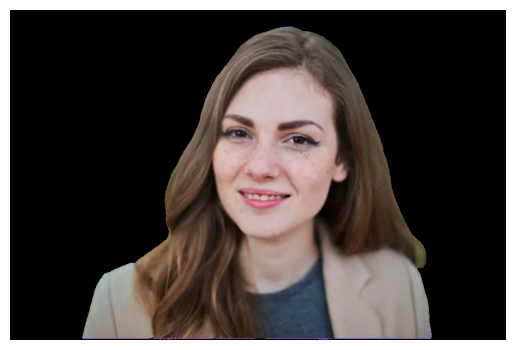

In [214]:
mask = segmented_mask[0]
inverted_mask = ~mask
# Subtract the mask from the image
new_img = image_original.copy()
new_img = cv2.subtract(new_img, inverted_mask)

#plt.imshow(new_img)
# Convert the image from BGR to RGB -----------
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [215]:
PERSON_IMAGE_PATH = os.path.join(work_dir, 'masked_'+image_file_name+ '.png')
cv2.imwrite(PERSON_IMAGE_PATH, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

True

# Superimpose image onto custom background

(-0.5, 1259.5, 706.5, -0.5)

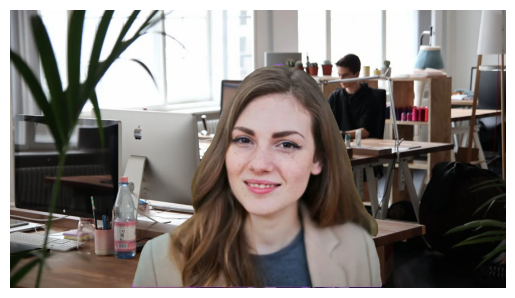

In [216]:
from PIL import Image

def overlayImage(person_img_path, bg_img_path):
  person_img = Image.open(person_img_path).convert("RGB")
  bg_img = Image.open(bg_img_path)

  person_img = cv2.cvtColor(np.array(person_img), cv2.COLOR_BGR2RGB)
  person_img = Image.fromarray(person_img)

  pixels_img1 = person_img.load()
  pixels_img2 = bg_img.load()

  # Get y-coordinate where person should start to appear at the bottom of background
  start_y = person_img.height - bg_img.height
  start_x = (bg_img.width - person_img.width) // 2
  # Iterate over each pixel -------
  for x in range(person_img.width):
      for y in range(person_img.height):
          # If pixel in person_img is not black (0), paste corresponding pixel from bg_img
          if pixels_img1[x, y] != (0, 0, 0):
              #pixels_img2[x, y] = pixels_img1[x, y]
              #pixels_img2[x, y - start_y] = pixels_img1[x, y]
              pixels_img2[x + start_x, y - start_y] = pixels_img1[x, y]
  return bg_img

person_img_path = PERSON_IMAGE_PATH #'/content/col_img.png'
bg_img_path = BACKGROUND_IMAGE_PATH #'/content/office_pexels-photo-380769.webp'
check1 = overlayImage(person_img_path, bg_img_path)
plt.imshow(check1)
plt.axis('off')

# Save superimposed image

In [220]:
#check1.save('/content/result/new_imposed.png')
import imageio
imageio.imwrite('/content/output_'+ image_file_name +'.jpg', check1)